In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import multiprocessing
from multiprocessing.pool import ThreadPool
import copy

import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from tqdm import tqdm
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from xgboost import XGBRegressor as xgb
from lightgbm import LGBMRegressor as lgbm
from catboost import CatBoostRegressor as cat
from sklearn.metrics import r2_score

from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA
import glob

C:\Anaconda3\lib\site-packages\backtesting\_plotting.py:37: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `bokeh.io.reset_output()`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
plt.rc('font',family='NanumGothic')

In [4]:
df_input   = pd.read_pickle('C:\\Users\\sakl7\\바탕 화면\\KUBIG\\backtesting\\data\\findust1.pkl')
stock_data = pd.read_csv('C:\\Users\\sakl7\\바탕 화면\\KUBIG\\alteda\\data\\stock\\003850.csv')

In [5]:
stock_data = stock_data.rename(columns={stock_data.columns[0]:'측정일시'})

In [6]:
stock_data = stock_data.drop(['Adj Close'],axis=1)

In [7]:
df_input.index = df_input['측정일시']

In [8]:
index_list = []

for i in tqdm(range(len(df_input))):
    index_list.append(datetime.datetime(int(df_input.index[i][0:4]),int(df_input.index[i][4:6]),int(df_input.index[i][6:8])))

df_input.index = index_list

100%|███████████████████████████████████████████████████████████████████████████| 6038/6038 [00:00<00:00, 85398.01it/s]


In [9]:
index_list = []
for i in tqdm(range(len(stock_data))):
    index_list.append(datetime.datetime(int(str(stock_data['측정일시'][i])[0:4]),
                                        int(str(stock_data['측정일시'][i])[4:6]),int(str(stock_data['측정일시'][i])[6:8])))
    
stock_data['측정일시'] = index_list
stock_data.index = stock_data['측정일시']

100%|████████████████████████████████████████████████████████████████████████████| 7792/7792 [00:00<00:00, 9815.68it/s]


In [10]:
stock_data = stock_data.drop(['측정일시'],axis=1)

In [11]:
stock_close = stock_data['Close']
df_input    = df_input['PM10']
others = stock_data[['Open', 'Close', 'High', 'Low', 'Volume']]

In [12]:
df_input
df = stock_data.merge(df_input, how='inner', left_on=stock_data.index, right_on=df_input.index)
df = df.drop([df.index[0]],axis=0)

In [13]:
df['key_0']

1      2001-01-03
2      2001-01-04
3      2001-01-05
4      2001-01-08
5      2001-01-09
          ...    
4082   2019-04-24
4083   2019-04-25
4084   2019-04-26
4085   2019-04-29
4086   2019-04-30
Name: key_0, Length: 4086, dtype: datetime64[ns]

In [14]:
# hyperparameter

time_shift = -1

In [15]:
df_original = copy.deepcopy(df)
df.index = df['key_0']

df = df.drop(['key_0'], axis=1)
df



,High,Low,Open,Close,Volume,PM10
key_0,,,,,,
2001-01-03,821,743,749,822,271570,86.25
2001-01-04,943,852,905,944,305220,74.9167
2001-01-05,999,905,905,957,342010,98.8333
2001-01-08,1050,937,955,988,443550,14.2083
2001-01-09,1024,965,999,988,219440,36.7083
...,...,...,...,...,...,...
2019-04-24,13350,12950,13000,13150,455360,47.7917
2019-04-25,13900,13200,13250,13850,1148812,32.5455
2019-04-26,14100,13400,13800,13550,663063,8.5


In [16]:
# process 


# target y (Future data)
df['y'] = df['Close'].shift(time_shift)
df = df[df['y'].notnull()]


# 왜 2018 12 31 이전만 함?
df = df[df.index <= df.index[-1]]
#datetime.datetime(2018,12,31)

# split train/test
y = df['y']
x = df.drop(['y','Open', 'High', 'Low'],axis=1)
others = df[['Open', 'Close', 'High', 'Low', 'Volume']]
x_columns = x.columns

In [17]:
df.index

DatetimeIndex(['2001-01-03', '2001-01-04', '2001-01-05', '2001-01-08',
               '2001-01-09', '2001-01-10', '2001-01-11', '2001-01-12',
               '2001-01-15', '2001-01-16',
               ...
               '2019-04-16', '2019-04-17', '2019-04-18', '2019-04-19',
               '2019-04-22', '2019-04-23', '2019-04-24', '2019-04-25',
               '2019-04-26', '2019-04-29'],
              dtype='datetime64[ns]', name='key_0', length=4085, freq=None)

In [18]:
x

,Close,Volume,PM10
key_0,,,
2001-01-03,822,271570,86.25
2001-01-04,944,305220,74.9167
2001-01-05,957,342010,98.8333
2001-01-08,988,443550,14.2083
2001-01-09,988,219440,36.7083
...,...,...,...
2019-04-23,12900,353524,76.2917
2019-04-24,13150,455360,47.7917
2019-04-25,13850,1148812,32.5455


In [19]:
df_input.index

DatetimeIndex(['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04',
               '2001-01-05', '2001-01-06', '2001-01-07', '2001-01-08',
               '2001-01-09', '2001-01-10',
               ...
               '2019-04-21', '2019-04-22', '2019-04-23', '2019-04-24',
               '2019-04-25', '2019-04-26', '2019-04-27', '2019-04-28',
               '2019-04-29', '2019-04-30'],
              dtype='datetime64[ns]', length=6038, freq=None)

In [20]:
x_train = x[x.index < datetime.datetime(2018,10,1)].values  
x_valid = x[x.index >= datetime.datetime(2018,10,1)].values
y_train = y[y.index < datetime.datetime(2018,10,1)].values
y_valid = y[y.index >= datetime.datetime(2018,10,1)].values
others_train = others[others.index < datetime.datetime(2018,10,1)]
others_valid = others[others.index >= datetime.datetime(2018,10,1)]

print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(3943, 3) (142, 3) (3943,) (142,)


In [21]:
num_threads = 10

0.9991482427672923 0.9075786799967918


C:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


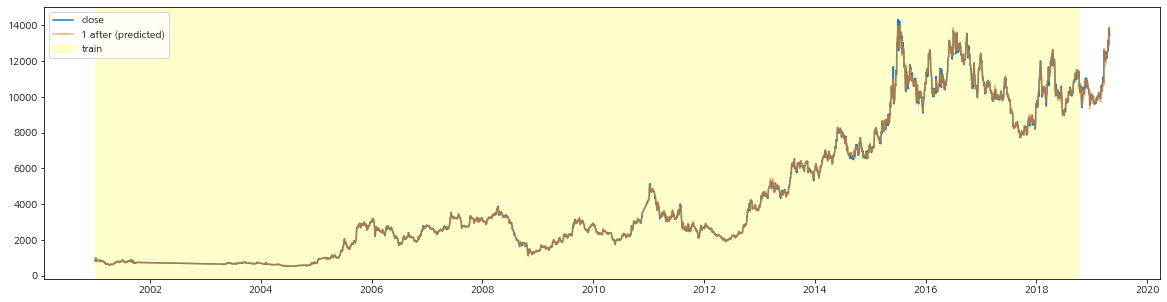

In [22]:
# model

model = lgbm(num_threads=num_threads)
#model = xgb(nthread=num_threads)
#model = cat(thread_count=num_threads, verbose=0)

model.fit(x_train, y_train)

y_train_hat = model.predict(x_train)
y_valid_hat = model.predict(x_valid)

print(r2_score(y_train, y_train_hat), r2_score(y_valid, y_valid_hat))

plt.figure(figsize=(20, 5))
plt.plot(df.index, df['Close'], label='close')
#plt.plot(df.index, pd.concat([pd.Series(y_train), pd.Series(y_valid)], ignore_index=True), label='%s after (close)' % (-time_shift))
plt.plot(df.index, pd.concat([pd.Series(y_train_hat), pd.Series(y_valid_hat)], ignore_index=True), 
         label='%s after (predicted)' % (-time_shift), alpha=0.6)
plt.axvspan(df.index[0], df.index[len(y_train)], alpha=0.2, color='yellow', label='train')

plt.legend()
plt.show()

In [23]:
others_valid

,Open,Close,High,Low,Volume
key_0,,,,,
2018-10-01,11600,11400,11800,11300,273623
2018-10-02,11350,11250,11500,11050,268640
2018-10-04,11300,11450,11500,11150,220187
2018-10-05,11350,11100,11400,10950,174180
2018-10-08,11100,11400,11550,11000,152633
...,...,...,...,...,...
2019-04-23,13150,12900,13200,12800,353524
2019-04-24,13000,13150,13350,12950,455360
2019-04-25,13250,13850,13900,13200,1148812


In [24]:
data = pd.DataFrame(x_valid, columns=x_columns)
data = data.merge(others_valid, how='inner')
data['Volume'] = data['Volume'].astype(float)
data['Close'] = data['Close'].astype(float)
data['PM10'] = pd.to_numeric(data['PM10'])
data1 = data.drop(['Open', 'High','Low'], axis=1)


yhat = model.predict(data1)
data['time shifted'] = yhat
data['date'] = others_valid.index


data

,Close,Volume,PM10,Open,High,Low,time shifted,date
0,11400.0,273623.0,16.083333,11600,11800,11300,11283.606492,2018-10-01
1,11250.0,268640.0,21.458333,11350,11500,11050,11058.408351,2018-10-02
2,11450.0,220187.0,19.083333,11300,11500,11150,11437.476481,2018-10-04
3,11100.0,174180.0,10.291667,11350,11400,10950,11302.898090,2018-10-05
4,11400.0,152633.0,20.541667,11100,11550,11000,11441.288075,2018-10-08
...,...,...,...,...,...,...,...,...
137,12900.0,353524.0,76.291667,13150,13200,12800,12979.941417,2019-04-23
138,13150.0,455360.0,47.791667,13000,13350,12950,13222.269082,2019-04-24
139,13850.0,1148812.0,32.545455,13250,13900,13200,13785.635672,2019-04-25
140,13550.0,663063.0,8.500000,13800,14100,13400,13934.538890,2019-04-26


In [26]:
class SmaCross(Strategy):

    def init(self):
        
        print(self.data)
        # 한줄씩 호출되는듯
        #self.data = data
        self.close = self.data['Close']
        self.time_shifted_price = self.data['time shifted']
        self.daycount = 0
        self.hold = False
        
        
    def next(self):

        if (self.close < self.time_shifted_price) and (self.hold == False):
            self.buy()
            self.hold = True
            self.daycount = 0
        
        elif (self.close >= self.time_shifted_price) and (self.hold == True):
            self.sell()
            self.hold = False
        
        elif (self.daycount > 2):
            self.sell()
            self.hold=False

    
        self.daycount += 1

In [27]:

bt = Backtest(data, SmaCross, cash=10000, commission=0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Data index is not datetime. Assuming simple periods.
  """Entry point for launching an IPython kernel.


In [28]:
bt.run()

Start                             0
End                             141
Duration                        141
Exposure [%]                98.5816
Equity Final [$]            17963.3
Equity Peak [$]             17963.3
Return [%]                   79.633
Buy & Hold Return [%]       17.9825
Max. Drawdown [%]          -15.0389
Avg. Drawdown [%]          -4.92309
Max. Drawdown Duration           43
Avg. Drawdown Duration      10.6667
# Trades                         69
Win Rate [%]                52.1739
Best Trade [%]              10.5023
Worst Trade [%]            -7.12871
Avg. Trade [%]              0.78731
Max. Trade Duration               3
Avg. Trade Duration         2.01449
Expectancy [%]              2.28661
SQN                         2.20225
Sharpe Ratio               0.250499
Sortino Ratio              0.532752
Calmar Ratio              0.0523517
_strategy                  SmaCross
dtype: object

In [29]:
bt.plot()